## Online available

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/carlos-adir/FEM-NURBS/blob/main/1-ODE/1-basics.ipynb)

This python notebook is available online in GitHub throught:

* [GitHub/carlos-adir/FEM-NURBS/1-ODE/1-basics.ipynb](https://github.com/carlos-adir/FEM-NURBS/blob/main/1-ODE/1-basics.ipynb)

In [1]:
try:
    from compmec import nurbs
except ModuleNotFoundError:
    import os
    os.system("pip install numpy")
    os.system("pip install mpmath")
    os.system("pip install matplotlib")
    os.system("pip install compmec-nurbs")
import numpy as np
from typing import Callable, Iterable, Optional, Tuple
from matplotlib import pyplot as plt
from compmec import nurbs  
from helpernurbs import getH, getD, Fit

# Theory - First part

There are a lot of methods to solve Ordinary differential equation (ODE), here we see one of them.

The method we apply is Finite Element Method (FEM) from Galerkin minimimal weighted residual using BSpline as base functions.

### Introduction

A first linear order is given by

$$
\dfrac{dT}{dt} = f(t)
$$

in the interval $t \in \left[a, \ b\right]$ and initial condition

$$
T(t = a) = T_a
$$

Solving this ODE analytically, we can get $T_{analitic}(t)$ which allows us to compare with the numerical solution.

To get our numeric solution, the inspiration from FEM is to get $\tilde{T}(t) \approx T(t)$ at the interval $\left[a, \ b\right]$.
This function $\tilde{T}(t)$ is described as a sum of $n$ weights $T_{i}$ multiplied by base functions $\varphi_{i}(t)$ of our choice:

$$\tilde{T}(t) = \sum_{j=0}^{n-1} T_j \cdot \varphi_{j}(t) = \left[\mathbf{T}\right]^{T}\cdot \left[\varphi\right] $$

Where $\left[\mathbf{T}\right]$ is the weight vector (which we want to find) and $\left[\varphi\right]$ is the vector with known base functions.

From now on we replace $\tilde{T}$ by $T$ to simplify the notation.

The Finite Element Method by Galerkin says we want to reduce the integral of the residual for each base function $\varphi_{i}$ (more details [here](https://www.youtube.com/watch?v=JmjdwhBkvq8)).

$$\int_{a}^{b} \left(\dfrac{dT}{dt}-f(t)\right) \cdot \varphi_{i} \ \ dt = 0 \ \ \ \ \forall \ i$$

Expanding

$$
\sum_{j} w_{j} \cdot \int_{a}^{b} \dfrac{\varphi_j}{dt} \cdot \varphi_{i} \ \ dt = \int_{a}^{b} f(t) \cdot \varphi_{i} \ \ dt \ \ \ \forall \ i
$$

Naming $A_{ij}$ and $B_{i}$ as constants, one can find a linear system:

$$
A_{ij} = \int_{a}^{b} \dfrac{\varphi_j}{dt} \cdot \varphi_i \ dt \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ B_{i} =  \int_{a}^{b}  \varphi_i  \cdot f  \ dt 
$$

$$
\underbrace{\begin{bmatrix}
A_{00} & A_{01} & \cdots & A_{0,n-1} \\
A_{10} & A_{11} & \cdots & A_{1,n-1} \\
\vdots & \vdots & \ddots & \vdots \\
A_{n-1,0} & A_{n-1,1} & \cdots & A_{n-1,n-1} \\
\end{bmatrix}}_{\mathbf{A}}
\underbrace{\begin{bmatrix}
T_{0} \\ T_1 \\ \vdots \\ T_{n-1}
\end{bmatrix}}_{\mathbf{T}}=
\underbrace{\begin{bmatrix}
B_{0} \\ B_1 \\ \vdots \\ B_{n-1}
\end{bmatrix}}_{\mathbf{B}}
$$

So, to find the wantted approximation $T(t)$, we only need to find the weights by solving the linear system $\mathbf{A} \cdot \mathbf{T} = \mathbf{B}$.

Como conhecemos as funções $[\varphi]$, então é possível calcular os termos de $[A]$ e $[B]$.
Podemos escolher as funções base $\left[\varphi\right]$ tais que muitos termos da matriz $[A]$ sejam zeros (logo, não precisamos calcular todos) e cujas integrais são fáceis de calcular.

### Base Functions

There a lot of base functions $\varphi$ we can use and for FEM they resume to [piecewise-functions](https://en.wikipedia.org/wiki/Piecewise).

For our case, we select a type of piecewise-functions which are the [NURBS](https://en.wikipedia.org/wiki/Non-uniform_rational_B-spline). 

> NURBS are a very complex and generic. If you are not used to it, watch an [introdutory video](https://youtu.be/jvPPXbo87ds)

They are mainly defined by the weight vector $\mathbf{w}$ and a knot-vector $\mathbf{U}$:

$$\mathbf{w} = \left[w_0, \ w_1, \ \cdots, \ w_{n-1}\right]_{n}$$
$$\mathbf{U} = \left[u_0, \ \cdots, \ u_{p}, \ u_{p+1}, \ \cdots, \ u_{n-1}, \ u_{n}, \ \cdots, \ u_{n+p} \right]_{n+p+1}$$
$$0 = u_0 = u_1 = \cdots = u_p < u_{p+1} \le \cdots \le u_{n-1} < u_{n} = \cdots = u_{n+p} = 1$$

The $n$ base functions are given by $R_{i,1}(u)$:

$$\mathbf{R}_{p} := \begin{bmatrix}R_{0,p} & R_{1,p} & \cdots & R_{n-1, p}\end{bmatrix}$$

* $i$ represents which function we select, $i=0, \ \cdots, \ n-1$
* $p$ represents the degree of the used polynomials
* $u$ is the function variable, which  $u \in \left[0, \ 1\right]$.

Their properties are

1. $R_{ij}$ is local
    $$R_{ij}(u) = 0 \ \ \ \ \ \ \forall \ u \notin \left[u_{i}, \ u_{i+j+1}\right) \ \ \ \ \ \ \ \ \ 0  \le j \le p$$
2. In $[u_{k},  \ u_{k+1}]$, only $j+1$ functions are non-zero
    $$R_{ij}(u) = 0 \ \ \ \text{on} \ \left[u_k, \ u_{k+1}\right] \ \ \ \text{if} \ i \notin \left\{k-j, \ \cdots, \ k\right\}$$
3. The derivative $\left[R_{j}'\right]$ is written using $\left[R_{j-1}\right]$
    $$\begin{align*}R_{ij}(u)' & = \alpha_{i,j} \cdot R_{i,j-1} - \alpha_{i+1,j} \cdot R_{i+1,j-1} \\ \alpha_{ij} & = \begin{cases}\frac{j}{u_{i+j}-u_{i}} \ \ \ \ \ \text{if} \ u_{i} \ne u_{i+j}\\ 0 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \text{else} \end{cases}\end{align*}$$

Therefore

$$\dfrac{d}{du}\begin{bmatrix}N_{0j} \\ N_{1j} \\ \vdots \\ N_{n-1,j}\end{bmatrix} = \underbrace{\begin{bmatrix} \alpha_{0} & -\alpha_{1} & & & \\ & \alpha_{1} & -\alpha_{2} & & \\ & & \ddots & \ddots &  \\ & & & \alpha_{n-2}& -\alpha_{n-1} \\ & & & & \alpha_{n-1} \end{bmatrix}}_{\left[D_j\right]}\begin{bmatrix}N_{0,j-1} \\ N_{1,j-1} \\ \vdots \\ N_{n-1,j-1}\end{bmatrix}$$

As further improvement for notation, we say that 

$$\mathbf{H}_{ab} := \int_0^1 \mathbf{R}^{(a)}_{p} \otimes \mathbf{R}^{(b)}_{p} \ du = \int_0^1 \left(\dfrac{d^a\mathbf{R}_{p}}{du^a}\right) \otimes \left(\dfrac{d^b\mathbf{R}_{p}}{du^b}\right) \ du$$



## Applying NURBS in FEM

To apply $R_{i,p}(u)$ at the place of $\varphi_{i}(t)$, a bijective transformation from space $S: t \to u$ is needed, which

$$\begin{cases}t = a \Rightarrow u = 0 \\ t = b \Rightarrow u = 1\end{cases}$$

The easiest (but not unique) is to use a linear interpolation:

$$t = (1-u) \cdot a + t \cdot b$$

Then

$$\begin{align*}\mathbf{A} & = \left(b-a\right) \int_{0}^{1} \mathbf{R}_{p} \otimes \left(\dfrac{d}{du}\mathbf{R}_{p}\right) \ du = \left(b-a\right) \cdot \mathbf{H}_{01} \\ \mathbf{B} & = \left(b-a\right) \int_{0}^{1} \mathbf{R}_{p} \cdot f(t(u)) \cdot \ du \end{align*}$$

The matrix $\mathbf{H}_{01}$ is not hard to compute and can be found [here](linktotheoryofcomputingH)

To find $\mathbf{B}$, it highly depends on the shape of $f(t(u))$. So we interpolate the function $f(t(u))$ into a $g(u)$ which is decomposed into a NURBS form:

$$\mathbf{R}_p \cdot \mathbf{G} = \sum_{i=0}^{n-1} R_{i,p}(u) \cdot G_{i} = g(u) \approx f(t(u))$$

Finding a fit to this is not hard, and can be found [here](linktotheoryoffit). Then

$$\mathbf{B} = \int_0^{1} \mathbf{R}_{p} \cdot f(t(u)) \ du = \int_{0}^{1} \mathbf{R}_p \otimes \mathbf{R}_{p} \ du \cdot \mathbf{G} = \mathbf{H}_{00} \cdot \mathbf{G}$$

Therefore

$$\mathbf{H}_{01} \cdot \mathbf{T} = \mathbf{H}_{00} \cdot \mathbf{G}$$

## Boundary conditions

The boundary conditions determine some values of $\mathbf{T}$ or a relation for $\mathbf{T}$.

* For Dirichlet condition at begin, $T(a) = T_a$ then

    $$T(t=a) = \sum_{j=0}^{n-1} R_{j,p}(u=0) \cdot T_{j} = T_{0} = T_a$$

* For Dirichlet condition at end, $T(b) = T_b$ then

    $$T(t=a) = \sum_{j=0}^{n-1} R_{j,p}(u=1) \cdot T_{j} = T_{n-1} = T_b$$

* For Neumann condition at begin, $\dfrac{dT}{dt}(a) = Q_a$

    $$\dfrac{dT}{dt}(t=a) = \left(b-a\right) \sum_{j=0}^{n-1}R_{j,p}(u=0) \cdot T_{j} = \dfrac{b-a}{u_{p+1}-u_{1}}\left(T_{1}-T_{0}\right) = Q_{a} $$
    
* For Neumann condition at end, $\dfrac{dT}{dt}(b) = Q_b$

    $$\dfrac{dT}{dt}(t=b) = \left(b-a\right) \sum_{j=0}^{n-1}R_{j,p}(u=1) \cdot T_{j} = \dfrac{b-a}{u_{n+p-1}-u_{n-1}}\left(T_{n-1}-T_{n-2}\right) = Q_{b} $$

Although these are simple ways to do it, it's possible to erase one line of the matrix $\mathbf{H}_{01}$ to put the boundary 

### Example 1

> Solve the EDO
>
> $$T' = \pi \cos \pi t$$
> $$0 \le t \le 1 \ \ \ \ \ \ T(0)=0$$
> 
> Analitic solution is
>
> $$T(t) = \sin \pi t$$
>
> Using 
> * Linear elements (degree 1) 
> * $11$ equally distant points
> * Uniform weight vector $\mathbf{w}$

In [2]:
def f(t):
    return np.pi*np.cos(np.pi*t)
a, b = 0, 1
Ta = 0
degree = 1
npts = 11

usample = np.linspace(0, 1, 129)
tsample = a+(b-a)*usample

U = nurbs.GeneratorKnotVector.uniform(degree=degree, npts=npts)
N = nurbs.SplineBaseFunction(U)
# Mount matrix A and B
H00 = getH(N, 0, 0)
H01 = getH(N, 0, 1)
A = (b-a)*H01
G = np.linalg.lstsq(N(usample).T, f(tsample), rcond=None)[0]
B = H00 @ G
# Boundary conditions
A[0, :] = N(0)
B[0] = Ta
# Solve linear system
Tvals = np.linalg.solve(A, B)

Text(0.5, 1.0, 'Error of numeric solution')

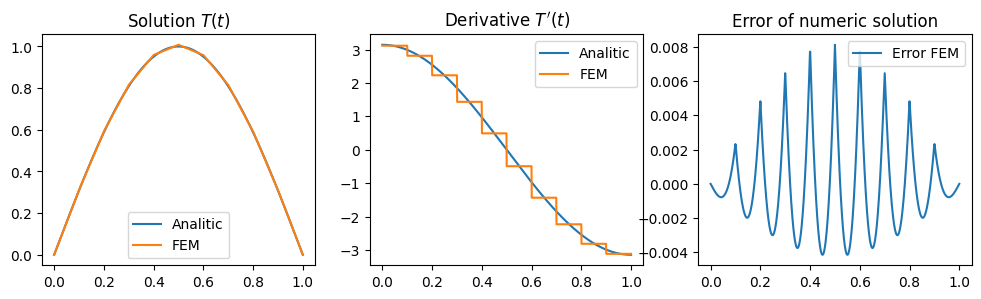

In [3]:
uplot = np.linspace(0, 1, 1025)
tplot = a+(b-a)*uplot

femplot = Tvals @ N[:, degree](uplot)
anaplot = np.sin(np.pi*tplot)

dfemplot = Tvals @ getD(degree, U) @ N[:, degree-1](uplot)
danaplot = f(tplot)

fig, axis = plt.subplots(1, 3, figsize=(12, 3))
axis[0].plot(tplot, anaplot, label=r"Analitic")
axis[0].plot(tplot, femplot, label=r"FEM")
axis[0].legend()
axis[0].set_title(r"Solution $T(t)$")

axis[1].plot(tplot, danaplot, label=r"Analitic")
axis[1].plot(tplot, dfemplot, label=r"FEM")
axis[1].legend()
axis[1].set_title(r"Derivative $T'(t)$")

axis[2].plot(tplot, femplot-anaplot, label=r"Error FEM")
axis[2].legend()
axis[2].set_title(r"Error of numeric solution")

### Example 2

> Solve the EDO
>
> $$T' = 2-2t+4t^2-4t^3-4t^4$$
> $$0 \le t \le 1 \ \ \ \ \ \ T(0)=1$$
> 
> Analitic solution
>
> $$T(t) = 1+2t-t^2+ \frac{4}{3}t^3-t^4-\frac{4}{5}t^5$$
> 
> Using 
> * Linear elements (degree 1) 
> * $7$ equally distant points
> * Uniform weight vector $\mathbf{w}$

In [4]:
def f(t):
    return 2 - 2*t + 4*t**2 - 4*t**3 - 4*t**4
a, b = 0, 1
Ta = 1
degree = 1
npts = 7

usample = np.linspace(0, 1, 129)
tsample = a+(b-a)*usample

U = nurbs.GeneratorKnotVector.uniform(degree=degree, npts=npts)
N = nurbs.SplineBaseFunction(U)
# Mount matrix A and B
H00 = getH(N, 0, 0)
H01 = getH(N, 0, 1)
A = (b-a)*H01
G = np.linalg.lstsq(N(usample).T, f(tsample), rcond=None)[0]
B = H00 @ G
# Boundary conditions
A[0, :] = N(0)
B[0] = Ta
# Solve linear system
Tvals = np.linalg.solve(A, B)

Text(0.5, 1.0, 'Error of numeric solution')

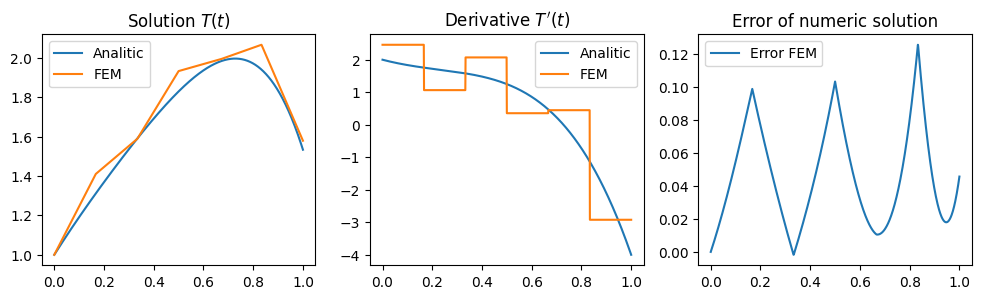

In [5]:
uplot = np.linspace(0, 1, 1025)
tplot = a+(b-a)*uplot

femplot = Tvals @ N[:, degree](uplot)
anaplot = 1 + 2*tplot - tplot**2 + (4/3)*tplot**3 - tplot**4 - (4/5)*tplot**5

dfemplot = Tvals @ getD(degree, U) @ N[:, degree-1](uplot)
danaplot = f(tplot)

fig, axis = plt.subplots(1, 3, figsize=(12, 3))
axis[0].plot(tplot, anaplot, label=r"Analitic")
axis[0].plot(tplot, femplot, label=r"FEM")
axis[0].legend()
axis[0].set_title(r"Solution $T(t)$")

axis[1].plot(tplot, danaplot, label=r"Analitic")
axis[1].plot(tplot, dfemplot, label=r"FEM")
axis[1].legend()
axis[1].set_title(r"Derivative $T'(t)$")

axis[2].plot(tplot, femplot-anaplot, label=r"Error FEM")
axis[2].legend()
axis[2].set_title(r"Error of numeric solution")

### Example 3

> Solve the EDO
>
> $$T' = \pi \cos \pi t$$
> $$0 \le t \le 1 \ \ \ \ \ \ T(0)=0$$
> 
> Analitic solution is
>
> $$T(t) = \sin \pi t$$
>
> Using 
> * Elements of degree $1$, $2$, $3$ and $4$
> * $5$ equally distant points
> * Uniform weight vector $\mathbf{w}$

In [6]:
def f(t):
    return np.pi * np.cos(np.pi*t)
a, b = 0, 1
Ta = 0
npts = 5

usample = np.linspace(0, 1, 129)
tsample = a+(b-a)*usample

femsolutions = {}
for degree in [1, 2, 3, 4]:
    U = nurbs.GeneratorKnotVector.uniform(degree, npts)
    N = nurbs.SplineBaseFunction(U)
    # Mount matrix
    H00 = getH(N, 0, 0)
    H01 = getH(N, 0, 1)
    A = (b-a) * H01
    # Montar a matriz B
    G = np.linalg.lstsq(N(usample).T, f(tsample), rcond=None)[0]
    B = (b-a) * H00 @ G
    # Initial conditions
    A[0] = N[:, degree](0)
    B[0] = Ta
    # Resolver o sistema
    Tvals = np.linalg.solve(A, B)
    femsolutions[degree] = (Tvals, N)

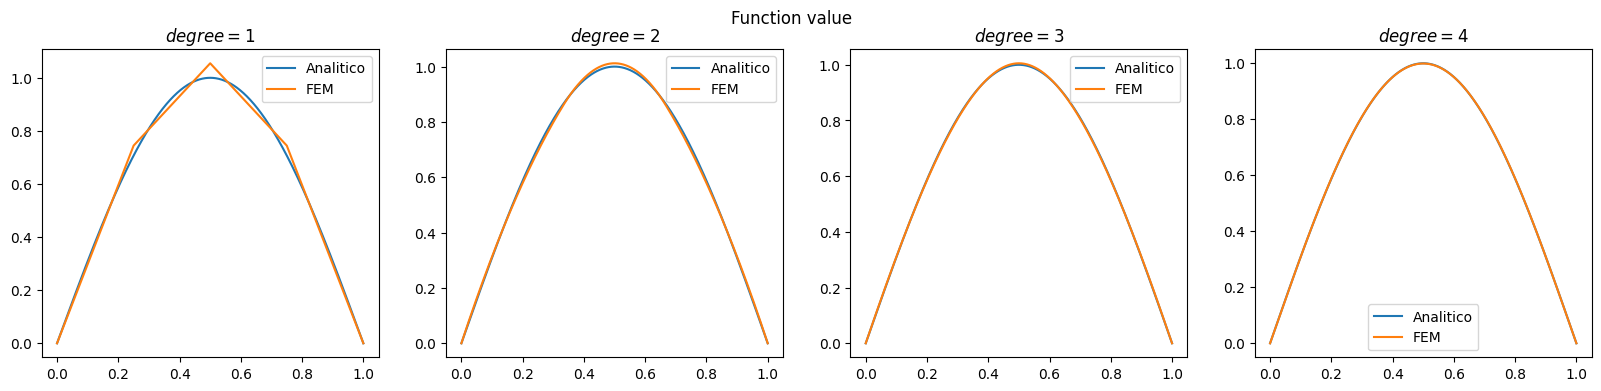

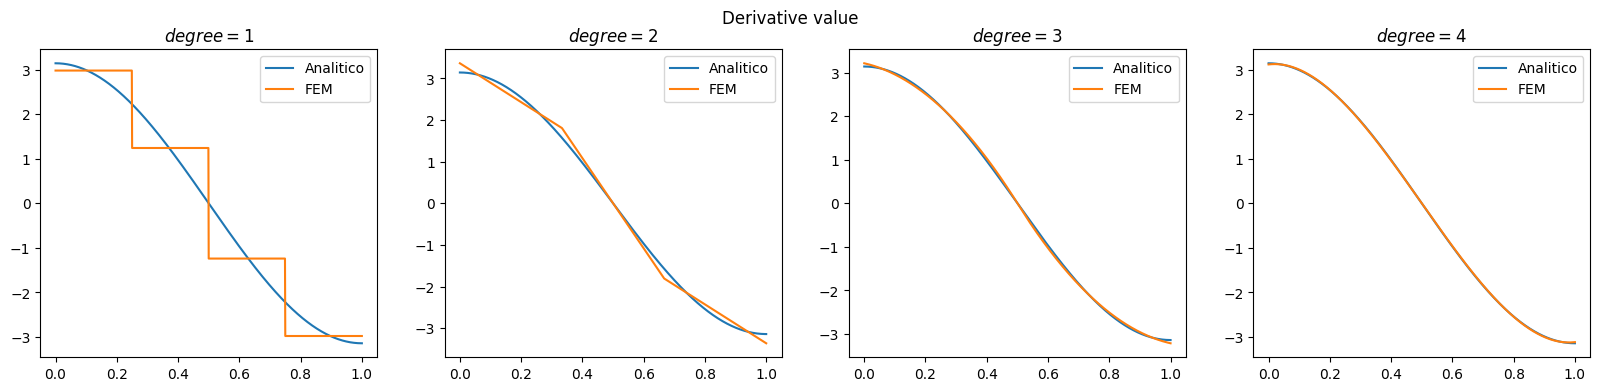

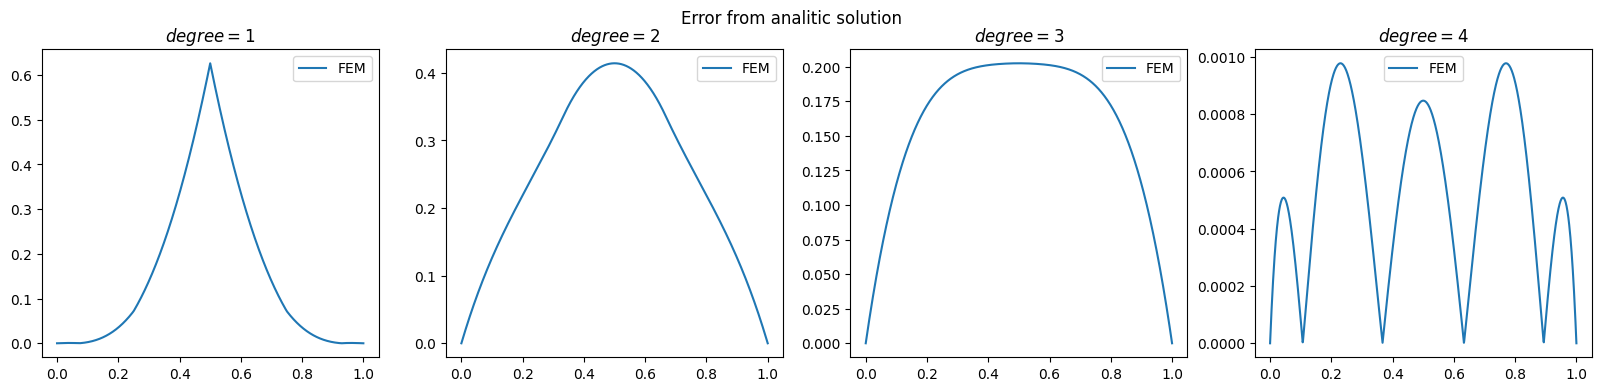

In [7]:
solution = lambda t: np.sin(np.pi*t)
dsolution = lambda t: f(t)

uplot = np.linspace(0, 1, 1025)
tplot = a+(b-a)*uplot
for derivative in range(2):
    fig, axis = plt.subplots(1, 4, figsize=(20, 4))
    for ooo, degree in enumerate([1, 2, 3, 4]):
        (wvals, N) = femsolutions[degree]
        n, p, U = N.npts, N.degree, N.knotvector
        Dp = getD(degree, U)
        if derivative == 0:
            fig.suptitle(r"Function value")
            Tplot = wvals @ N[:, p](uplot)
            axis[ooo].plot(uplot, solution(uplot), label=r"Analitico")
            axis[ooo].plot(uplot, Tplot, label=r"FEM")
        elif derivative == 1:
            fig.suptitle(r"Derivative value")
            dTplot = wvals @ Dp @ N[:, degree-1](uplot)
            axis[ooo].plot(uplot, dsolution(uplot), label=r"Analitico")
            axis[ooo].plot(uplot, dTplot, label=r"FEM")
        axis[ooo].legend()
        axis[ooo].set_title(r"$degree = %d$"%p)

fig, axis = plt.subplots(1, 4, figsize=(20, 4))
for ooo, degree in enumerate([1, 2, 3, 4]):
    (wvals, N) = femsolutions[degree]
    n, p, U = N.npts, N.degree, N.knotvector
    Dp = getD(degree, U)
    fig.suptitle(r"Error from analitic solution")
    Tplot = Tvals @ N[:, p](uplot)
    axis[ooo].plot(tplot, np.abs(solution(uplot)-Tplot), label=r"FEM")
    axis[ooo].legend()
    axis[ooo].set_title(r"$degree = %d$"%p)

### Example 4

> Solve the EDO
>
> $$T' = 2-2t+4t^2-4t^3-4t^4$$
> $$0 \le t \le 1 \ \ \ \ \ \ T(0)=1$$
> 
> Analitic solution
>
> $$T(t) = 1+2t-t^2+ \frac{4}{3}t^3-t^4-\frac{4}{5}t^5$$
> 
> Using 
> * Elements of degree $1$, $2$, $3$ and $4$
> * $5$ equally distant points
> * Uniform weight vector $\mathbf{w}$

In [8]:
def f(t):
    return 2 - 2*t + 4*t**2 - 4*t**3 - 4*t**4
a, b = 0, 1
Ta = 1
npts = 7

usample = np.linspace(0, 1, 129)
tsample = a+(b-a)*usample

femsolutions = {}
for degree in [1, 2, 3, 4]:
    U = nurbs.GeneratorKnotVector.uniform(degree, npts)
    N = nurbs.SplineBaseFunction(U)
    # Mount matrix
    H00 = getH(N, 0, 0)
    H01 = getH(N, 0, 1)
    A = (b-a) * H01
    # Montar a matriz B
    G = np.linalg.lstsq(N(usample).T, f(tsample), rcond=None)[0]
    B = (b-a) * H00 @ G
    # Initial conditions
    A[0] = N[:, degree](0)
    B[0] = Ta
    # Resolver o sistema
    Tvals = np.linalg.solve(A, B)
    femsolutions[degree] = (Tvals, N)

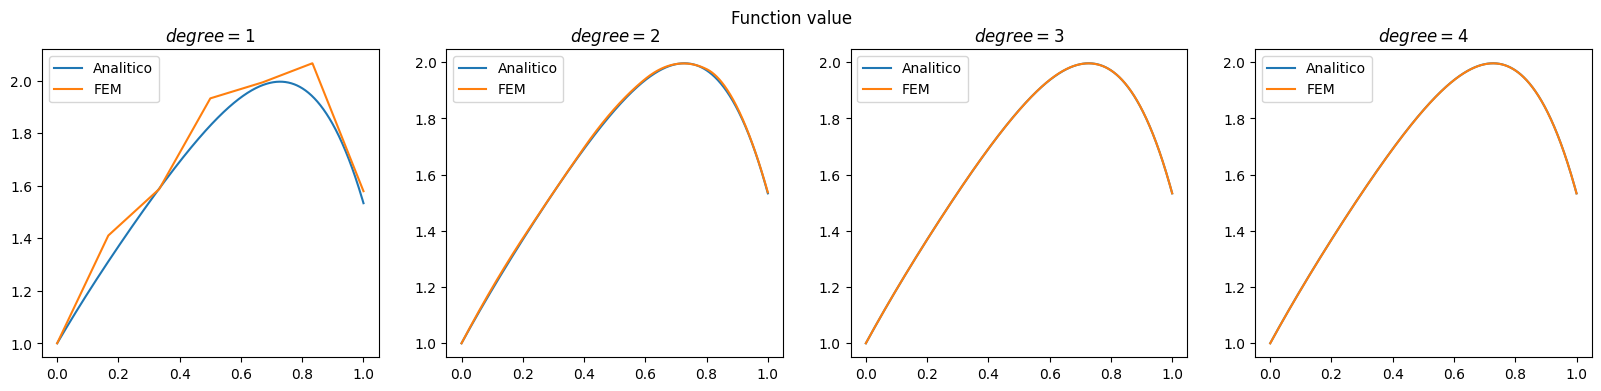

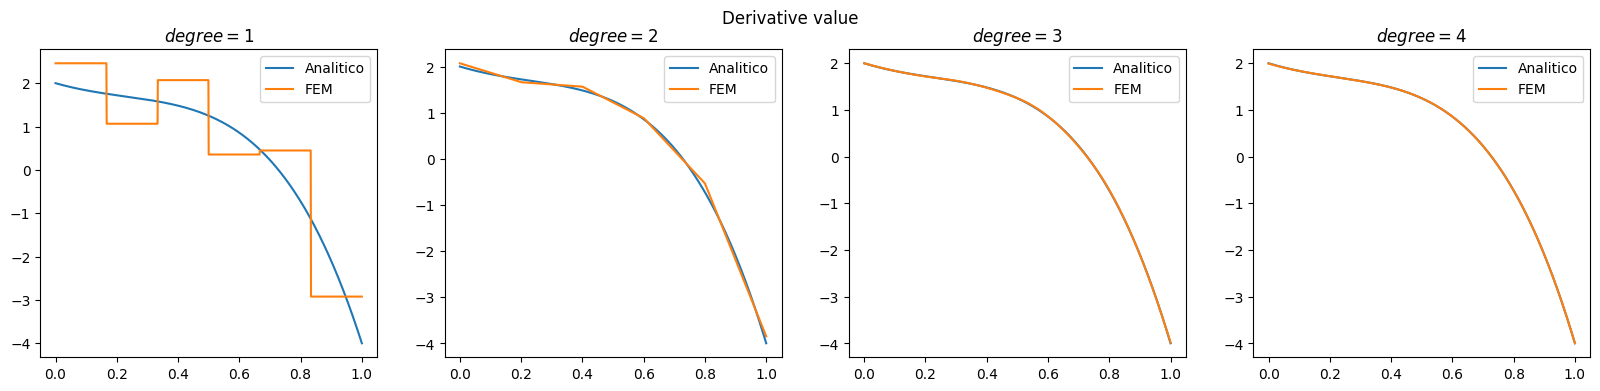

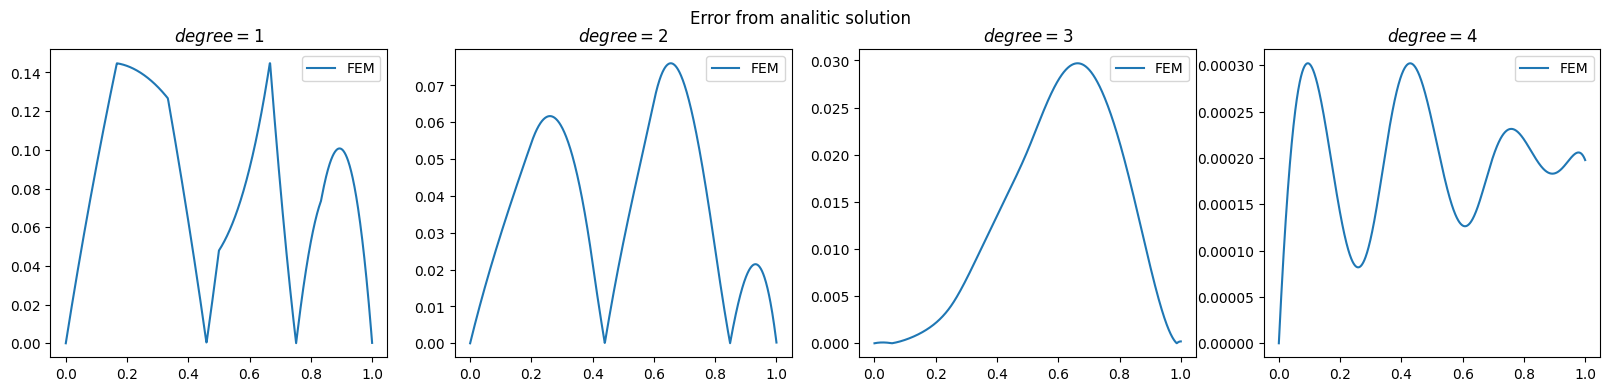

In [9]:
solution = lambda t: 1 + 2*t - t**2 + (4/3)*t**3 - t**4 - (4/5)*t**5
dsolution = lambda t: f(t)

uplot = np.linspace(0, 1, 1025)
tplot = a+(b-a)*uplot
for derivative in range(2):
    fig, axis = plt.subplots(1, 4, figsize=(20, 4))
    for ooo, degree in enumerate([1, 2, 3, 4]):
        (wvals, N) = femsolutions[degree]
        n, p, U = N.npts, N.degree, N.knotvector
        Dp = getD(degree, U)
        if derivative == 0:
            fig.suptitle(r"Function value")
            wplot = wvals @ N[:, p](uplot)
            axis[ooo].plot(uplot, solution(uplot), label=r"Analitico")
            axis[ooo].plot(uplot, wplot, label=r"FEM")
        elif derivative == 1:
            fig.suptitle(r"Derivative value")
            dwplot = wvals @ Dp @ N[:, degree-1](uplot)
            axis[ooo].plot(uplot, dsolution(uplot), label=r"Analitico")
            axis[ooo].plot(uplot, dwplot, label=r"FEM")
        axis[ooo].legend()
        axis[ooo].set_title(r"$degree = %d$"%p)

fig, axis = plt.subplots(1, 4, figsize=(20, 4))
for ooo, degree in enumerate([1, 2, 3, 4]):
    (wvals, N) = femsolutions[degree]
    n, p, U = N.npts, N.degree, N.knotvector
    Dp = getD(degree, U)
    fig.suptitle(r"Error from analitic solution")
    Tplot = Tvals @ N[:, p](uplot)
    axis[ooo].plot(tplot, np.abs(solution(uplot)-Tplot), label=r"FEM")
    axis[ooo].legend()
    axis[ooo].set_title(r"$degree = %d$"%p)